In [1]:
import os
import gym
from keras import backend as K
from keras import optimizers
from _base import build_env, experiment_dir
from _top_level import top_level
top_level()

Using TensorFlow backend.


In [2]:
from src.agents import DeepQAgent
from src.base import AnnealingVariable
from src.wrappers import wrap
from src.models.losses import huber_loss
from src.callbacks import BaseCallback
from src.callbacks import JupyterCallback
from src.utils import seed

# Environment

In [3]:
env_id = 'PongNoFrameskip-v4'
env_id

'PongNoFrameskip-v4'

In [4]:
# set the global random number seed
seed(1)

In [5]:
# create the output directory for this experiment's data
output_dir = experiment_dir('../results', env_id, DeepQAgent.__name__)
output_dir

'../results/PongNoFrameskip-v4/DeepQAgent/2019-01-20_11-34'

In [6]:
def make_environment(monitor: bool=False, seed: int=1) -> gym.Env:
    """
    Make a gym environment for training, validation, or testing.

    Args:
        monitor: whether to apply a monitor to the environment
        seed: an optional random number seed for the environment

    Returns:
        a build gym environment with necessary wrappers applied

    """
    # make the environment
    env = gym.make(env_id)
    # wrap the environment with transformers
    env = wrap(env, 
        cache_rewards=True,
        noop_max=30,
        frame_skip=4,
        max_frame_skip=False,
        image_size=(84, 84),
        death_penalty=-1,
        clip_rewards=True,
        agent_history_length=4
    )
    # monitor the video / data feed from the environment
    if monitor:
        monitor_dir = os.path.join(output_dir, 'monitor')
        env = gym.wrappers.Monitor(env, monitor_dir, force=True)
    # set the RNG seed for the environment
    if seed is not None:
        env.unwrapped.seed(seed)

    return env

In [7]:
env = make_environment()

# Training

In [8]:
# create a file to save the weights to
weights_file = os.path.join(output_dir, 'weights.h5')

In [9]:
# create an agent
agent = DeepQAgent(env,
    replay_memory_size=750000,
    prioritized_experience_replay=False,
    discount_factor=0.99,
    update_frequency=4,
    optimizer=optimizers.Adam(lr=2e-5),
    exploration_rate=AnnealingVariable(initial_value=1.0, final_value=0.01, steps=1e6),
    loss=huber_loss,
    target_update_freq=10000,
    dueling_network=False,
)
agent

DeepQAgent(
    env=<FrameStackEnv<ClipRewardEnv<PenalizeDeathEnv<DownsampleEnv<FrameSkipEnv<FireResetEnv<NoopResetEnv<RewardCacheEnv<TimeLimit<AtariEnv<PongNoFrameskip-v4>>>>>>>>>>>,
    render_mode=None
    replay_memory_size=750000,
    prioritized_experience_replay=False,
    discount_factor=0.99,
    update_frequency=4,
    optimizer=<keras.optimizers.Adam object at 0x7fb1633aa208>,
    exploration_rate=AnnealingVariable(initial_value=1.0, final_value=0.01, steps=1000000),
    loss=huber_loss,
    target_update_freq=10000,
    dueling_network=False
)

In [10]:
# observe random movement to pre-fill replay experience queue
agent.observe()

50336frame [00:33, 1503.99frame/s]                        


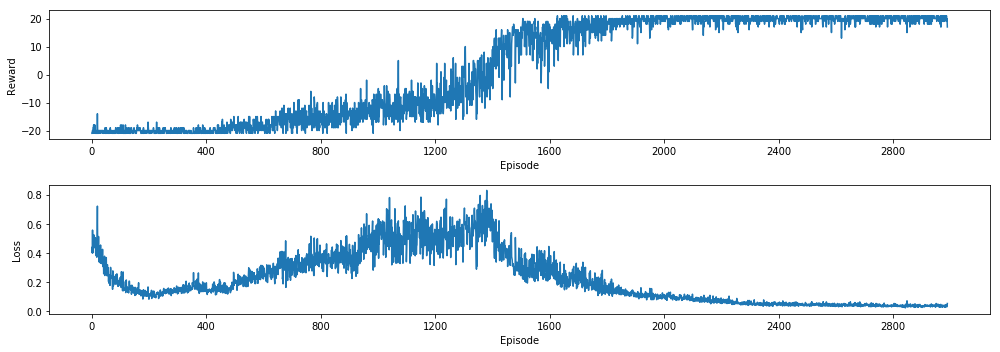

6001283frame [5:56:42, 283.28frame/s, loss=0.0542, score=17]                            


In [11]:
# create a callback for the training procedure to log weights and metrics
callback = BaseCallback(weights_file)
# create a callback for the training procedure to plot in Jupyter
plotter = JupyterCallback()
# train the agent with given parameters and callbacks
agent.train(6e6, callback=[callback, plotter])
# save the weights to disk after the training procedure
agent.model.save_weights(weights_file, overwrite=True)

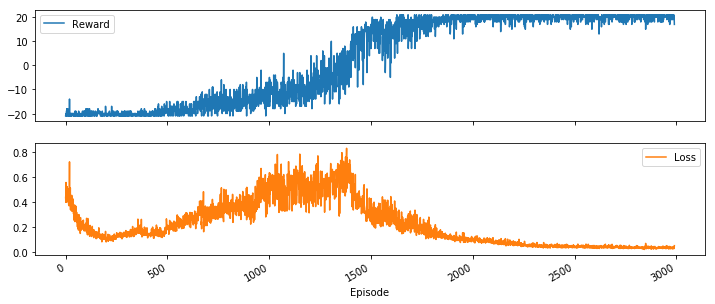

In [12]:
# export plot data from the base callback to disk
callback.export(os.path.join(output_dir, 'training'))

In [13]:
# close the training environment
env.close()
# clear the keras session to remove the training model from memory
K.clear_session()

# Validation

In [23]:
# create an environment for validation with a monitor attached
env = make_environment()
# create a validation agent
agent = DeepQAgent(env)
# load the trained weights into the validation agent
agent.model.load_weights(weights_file)

In [24]:
# run the agent through validation episodes
df = agent.play()



  0%|          | 0/100 [00:00<?, ?game/s]

  0%|          | 0/100 [00:00<?, ?game/s, score=?]

  0%|          | 0/100 [00:02<?, ?game/s, score=21]

  1%|          | 1/100 [00:02<04:41,  2.84s/game, score=21]

  1%|          | 1/100 [00:02<04:41,  2.84s/game, score=21]

  1%|          | 1/100 [00:05<04:41,  2.84s/game, score=21]

  2%|▏         | 2/100 [00:05<04:40,  2.86s/game, score=21]

  2%|▏         | 2/100 [00:05<04:40,  2.86s/game, score=21]

  2%|▏         | 2/100 [00:08<04:40,  2.86s/game, score=21]

  3%|▎         | 3/100 [00:08<04:40,  2.89s/game, score=21]

  3%|▎         | 3/100 [00:08<04:40,  2.89s/game, score=21]

  3%|▎         | 3/100 [00:11<04:40,  2.89s/game, score=21]

  4%|▍         | 4/100 [00:11<04:38,  2.90s/game, score=21]

  4%|▍         | 4/100 [00:11<04:38,  2.90s/game, score=21]

  4%|▍         | 4/100 [00:14<04:38,  2.90s/game, score=21]

  5%|▌         | 5/100 [00:14<04:39,  2.94s/game, score=21]

  5%|▌         | 5/100 [00:14<04:39,  2.94s/game, score=2

 40%|████      | 40/100 [02:07<02:42,  2.71s/game, score=21]

 40%|████      | 40/100 [02:10<02:42,  2.71s/game, score=21]

 41%|████      | 41/100 [02:10<02:39,  2.71s/game, score=21]

 41%|████      | 41/100 [02:10<02:39,  2.71s/game, score=21]

 41%|████      | 41/100 [02:13<02:39,  2.71s/game, score=21]

 42%|████▏     | 42/100 [02:13<02:36,  2.70s/game, score=21]

 42%|████▏     | 42/100 [02:13<02:36,  2.70s/game, score=21]

 42%|████▏     | 42/100 [02:16<02:36,  2.70s/game, score=19]

 43%|████▎     | 43/100 [02:16<02:38,  2.78s/game, score=19]

 43%|████▎     | 43/100 [02:16<02:38,  2.78s/game, score=19]

 43%|████▎     | 43/100 [02:18<02:38,  2.78s/game, score=20]

 44%|████▍     | 44/100 [02:18<02:34,  2.76s/game, score=20]

 44%|████▍     | 44/100 [02:18<02:34,  2.76s/game, score=20]

 44%|████▍     | 44/100 [02:21<02:34,  2.76s/game, score=20]

 45%|████▌     | 45/100 [02:21<02:32,  2.78s/game, score=20]

 45%|████▌     | 45/100 [02:21<02:32,  2.78s/game, score=20]

 45%|███

 80%|████████  | 80/100 [04:07<00:59,  2.99s/game, score=21]

 80%|████████  | 80/100 [04:10<00:59,  2.99s/game, score=21]

 81%|████████  | 81/100 [04:10<00:56,  2.98s/game, score=21]

 81%|████████  | 81/100 [04:10<00:56,  2.98s/game, score=21]

 81%|████████  | 81/100 [04:13<00:56,  2.98s/game, score=19]

 82%|████████▏ | 82/100 [04:13<00:55,  3.11s/game, score=19]

 82%|████████▏ | 82/100 [04:13<00:55,  3.11s/game, score=19]

 82%|████████▏ | 82/100 [04:17<00:55,  3.11s/game, score=17]

 83%|████████▎ | 83/100 [04:17<00:56,  3.30s/game, score=17]

 83%|████████▎ | 83/100 [04:17<00:56,  3.30s/game, score=17]

 83%|████████▎ | 83/100 [04:20<00:56,  3.30s/game, score=21]

 84%|████████▍ | 84/100 [04:20<00:51,  3.19s/game, score=21]

 84%|████████▍ | 84/100 [04:20<00:51,  3.19s/game, score=21]

 84%|████████▍ | 84/100 [04:23<00:51,  3.19s/game, score=17]

 85%|████████▌ | 85/100 [04:23<00:50,  3.33s/game, score=17]

 85%|████████▌ | 85/100 [04:23<00:50,  3.33s/game, score=17]

 85%|███

In [25]:
df.head()

,Score
Episode,
0,21.0
1,21.0
2,21.0
3,21.0
4,21.0


In [26]:
df.tail()

,Score
Episode,
95,18.0
96,21.0
97,20.0
98,21.0
99,21.0


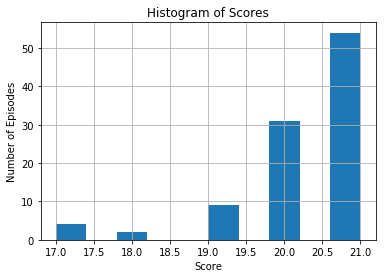

In [27]:
# plot the validation results and save the tables and figures to disk
agent.plot_episode_rewards(os.path.join(output_dir, 'play'))

In [28]:
env.close()